<a href="https://colab.research.google.com/github/doudi25/Scientific-machine-learning-PINN-/blob/main/pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def exact_solution(d,w0,t):
  w=np.sqrt(w0**2-d**2)
  phi=np.arctan(-d/w)
  A=1/(2*np.cos(phi))
  cos=torch.cos(w*t+phi)
  exp=torch.exp(-d*t)
  u=2*exp*A*cos
  return u

In [ ]:
class MLP(nn.Module):
  def __init__(self,in_feat,out_feat,hidden_dim,layers):
    super().__init__()
    self.linear1=nn.Sequential(*[nn.Linear(in_feat,hidden_dim),nn.Tanh()])
    self.hidden=nn.Sequential(*[nn.Sequential(*[nn.Linear(hidden_dim,hidden_dim),nn.Tanh()]) for _ in range(layers-1)])
    self.out=nn.Linear(hidden_dim,out_feat)
  def forward(self,x):
    x=self.linear1(x)
    x=self.hidden(x)
    x=self.out(x)
    return x

In [ ]:
torch.manual_seed(123)
pinn=MLP(1,1,32,3)
t_boundary=torch.tensor(0.,requires_grad=True).view(-1,1)
t_physics=torch.linspace(0,1,30,requires_grad=True).view(-1,1)



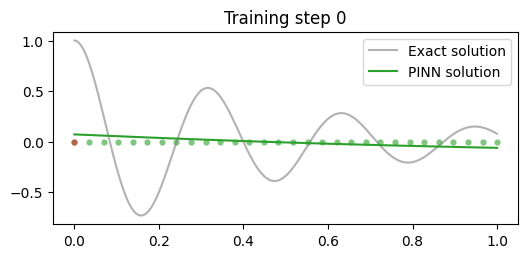

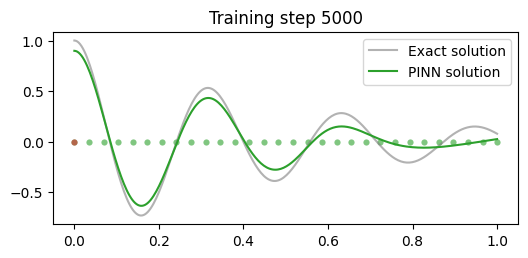

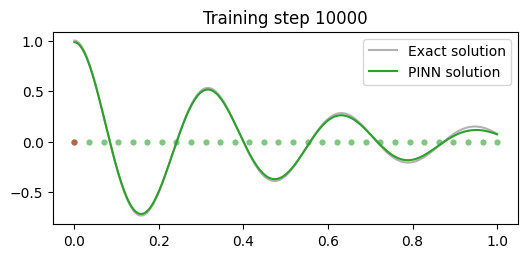

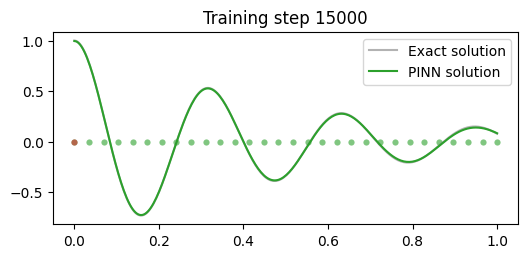

In [ ]:
d,w0=2,20
mu,k=2*d,w0**2
t_test=torch.linspace(0,1,300).view(-1,1)
u_exact=exact_solution(d,w0,t_test)
optimiser=torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(15001):
  optimiser.zero_grad()
  u=pinn(t_boundary)
  lambda1,lambda2=1e-1,1e-3
  dudt=torch.autograd.grad(u,t_boundary,torch.ones_like(u),create_graph=True)[0]
  loss1=torch.squeeze((u-1)**2)
  loss2=torch.squeeze((dudt-0)**2)
  u=pinn(t_physics)
  dudt=torch.autograd.grad(u,t_physics,torch.ones_like(u),create_graph=True)[0]
  dudt2=torch.autograd.grad(dudt,t_physics,torch.ones_like(u),create_graph=True)[0]
  loss3=torch.mean((dudt2+mu*dudt+k*u)**2)
  loss=loss1+lambda1*loss2+lambda2*loss3
  loss.backward()
  optimiser.step()
  if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()